##Imports and Setup

In [ ]:
# parameters
target_directory = '/content/drive/My Drive/Thesis_Repo/Code'
target_dataset = 'Googlemap_CT'
run_classification_model = False

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir(target_directory)

Mounted at /content/drive


In [ ]:
!pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import logging
import time
import sys
import os
from tqdm import tqdm
import numpy as np
import warnings
import shutil
import json
import torch
import torch.nn as nn
from bert_score import score as bert_sim_score
import pandas as pd
import pickle


from models.TGAT import TGAT
from models.MemoryModel import MemoryModel, compute_src_dst_node_time_shifts
from models.CAWN import CAWN
from models.TCL import TCL
from models.GraphMixer import GraphMixer
from models.DyGFormer import DyGFormer
from models.modules import NMergeLayer
from utils.utils import set_random_seed, convert_to_gpu, get_parameter_sizes, create_optimizer
from utils.utils import get_neighbor_sampler, NegativeEdgeSampler
from evaluate_models_utils import evaluate_model_link_recommendation, evaluate_model_retrival
from utils.metrics import get_link_prediction_metrics
from utils.DataLoader import get_idx_data_loader, get_link_prediction_data, get_link_recomendation_data #, Data
from utils.EarlyStopping import EarlyStopping
from utils.load_configs import get_link_prediction_args
from utils.utils import NeighborSampler
from utils.metrics import get_edge_classification_metrics

In [ ]:
input_args = "train_link_recomendation.py --dataset_name " + target_dataset + " --model_name DyGFormer --patch_size 2 --max_input_sequence_length 64 --num_runs 1 --num_epochs 8 --test_interval_epochs 1 --gpu 0 --use_feature Bert"
sys.argv = input_args.split(" ")
warnings.filterwarnings('ignore')
# Just use this helper function to prep args
args = get_link_prediction_args(is_evaluation=False)
args.classification = run_classification_model

## [Run once per dataset] Initial Data Setup

In [ ]:
# Can skip this step if already run in Run_DTGB_Train_Edge_Classification.ipynb

from get_pretrained_embeddings import get_pretrained_embeddings

get_pretrained_embeddings(args.dataset_name)

In [ ]:
# generate data

edge_texts = pd.read_csv('../DyLink_Datasets/' + args.dataset_name + '/relation_text.csv')

# get train/validation/test data
node_raw_features, edge_raw_features, full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data, train_data_edges, full_data_edges = \
    get_link_recomendation_data(dataset_name=args.dataset_name, val_ratio=args.val_ratio, test_ratio=args.test_ratio, edge_texts = edge_texts, args = args)

# save info
processed_data = [node_raw_features, edge_raw_features, full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data, train_data_edges, full_data_edges]
with open('../DyLink_Datasets/' + args.dataset_name + '/processed_data_no_labels_2.pkl', 'wb') as file:
    pickle.dump(processed_data, file)

In [ ]:
# compute labels for generated data

edge_texts = pd.read_csv('../DyLink_Datasets/' + args.dataset_name + '/relation_text.csv')

# load precomputed train/validation/test data
with open('../DyLink_Datasets/' + args.dataset_name + '/processed_data_no_labels_2.pkl', 'rb') as file:
    processed_data = pickle.load(file)
node_raw_features, edge_raw_features, full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data, train_data_edges, full_data_edges = processed_data

train_data.reduce_ref_count(0.436)
val_data.reduce_ref_count(0.326)
test_data.reduce_ref_count(0.266)
new_node_test_data.reduce_ref_count(0.347)

for data in [train_data, val_data, test_data, new_node_val_data, new_node_test_data]:
  data.labels.fill(-1)

for data in [train_data, val_data, test_data, new_node_val_data, new_node_test_data]:
  i = 0
  while(not data.update_labels(10000, edge_texts)):
    i += 1
    if i % 10 == 0:
      print(i)
  # Periodic checkpointing: not rly necessary anymore
  processed_data = [node_raw_features, edge_raw_features, full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data, train_data_edges, full_data_edges]
  with open('../DyLink_Datasets/' + args.dataset_name + '/processed_data.pkl', 'wb') as file:
    pickle.dump(processed_data, file)
  print("Done one dataset")

# Recompile full data
full_data = train_data.calc_merged(val_data).calc_merged(new_node_val_data)
full_data = full_data.calc_merged(test_data).calc_merged(new_node_test_data)


processed_data = [node_raw_features, edge_raw_features, full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data, train_data_edges, full_data_edges]
with open('../DyLink_Datasets/' + args.dataset_name + '/processed_data.pkl', 'wb') as file:
    pickle.dump(processed_data, file)

## [Optional] Data Analysis

In [ ]:
dataset_name = 'Amazon_movies'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.DataLoader import Data

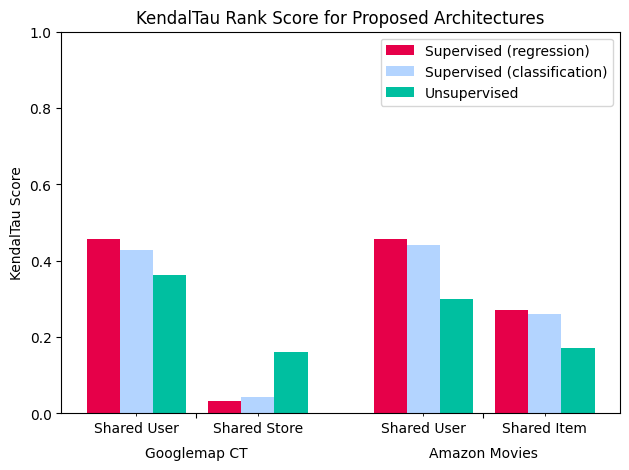

In [ ]:
# Data structure
main_groups = ['Googlemap CT', 'Amazon Movies']
subgroups = {
    'Googlemap CT': ['Shared User', 'Shared Store'],
    'Amazon Movies': ['Shared User', 'Shared Item']
}
categories = ['Supervised (regression)', 'Supervised (classification)', 'Unsupervised']

# Sample data
values = {
    'Googlemap CT': {
        'Shared User': [0.4573, 0.4267, 0.3616],
        'Shared Store': [0.0331, 0.0437, 0.1604]
    },
    'Amazon Movies': {
        'Shared User': [0.4573, 0.4416, 0.2990],
        'Shared Item': [0.2711, 0.2605, 0.1711]
    }
}

# Colors
colors = ["#fd7f6f", "#7eb0d5", "#bd7ebe"]
colors = ["#e60049", "#b3d4ff", "#00bfa0"]

# Layout calculations
width = 0.15
group_padding = 0.3
subgroup_padding = 0.1

# Create positions for bars
positions = []
labels = []
x_ticks = []
x_tick_labels = []

current_pos = 0
for main_group in main_groups:
    sub_positions = []
    for i, subgroup in enumerate(subgroups[main_group]):
        if i > 0:
            current_pos += subgroup_padding
        for j in range(3):
            sub_positions.append(current_pos + j * width)
        labels.extend([subgroup] * 3)
        current_pos += 3 * width
    positions.extend(sub_positions)
    x_ticks.append(current_pos - (3 * width * len(subgroups[main_group]) + subgroup_padding) / 2)
    x_tick_labels.append(main_group)
    current_pos += group_padding

# Plot bars
for i, color in enumerate(colors):
    category_positions = positions[i::3]
    category_values = []
    for main_group in main_groups:
        for subgroup in subgroups[main_group]:
            category_values.append(values[main_group][subgroup][i])
    plt.bar(category_positions, category_values, width, label=categories[i], color=color)

# Customize plot
plt.ylabel('KendalTau Score')
plt.ylim(0, 1.0)
plt.title('KendalTau Rank Score for Proposed Architectures')
plt.xticks(ticks=[x - 0.08 for x in x_ticks], labels=x_tick_labels, y=-0.06)  # Shifted left by 0.2
plt.legend()

# Add subgroup labels shifted by one bar width
plt.gca().set_xticks([pos + width for pos in positions[::3]], minor=True)
plt.gca().set_xticklabels(labels[::3], minor=True, rotation=0)

plt.tight_layout()
plt.show()

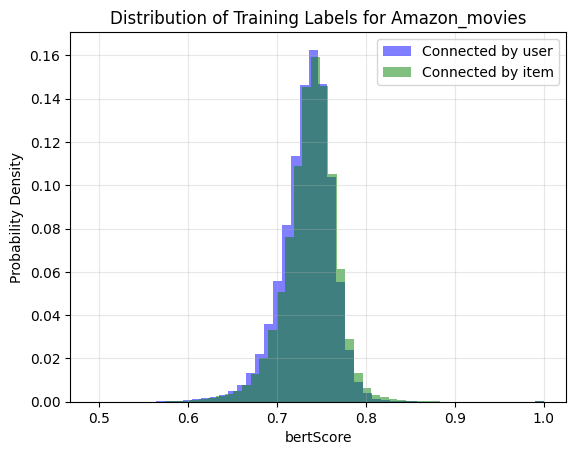

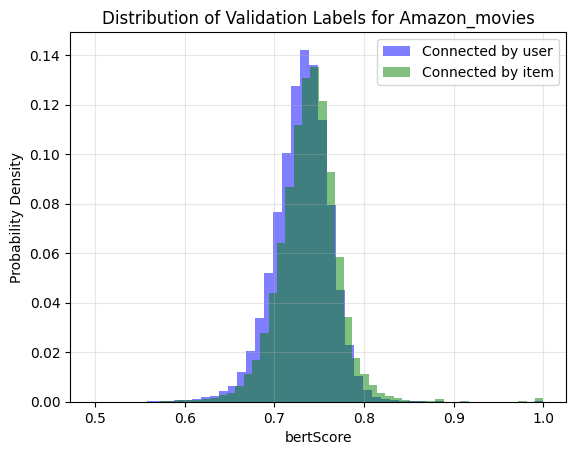

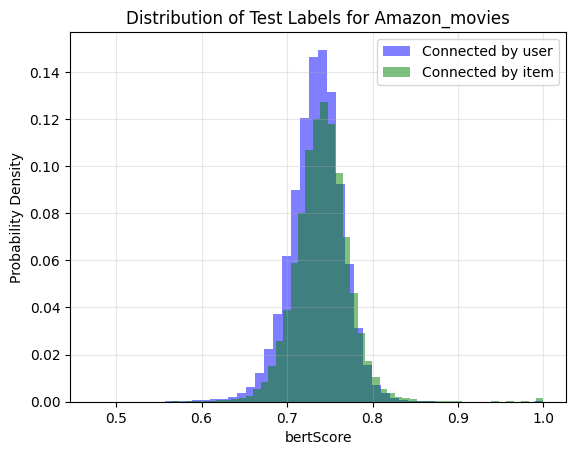

In [ ]:
import matplotlib.pyplot as plt
import pickle
dataset_name = 'Amazon_movies'
with open('../DyLink_Datasets/' + dataset_name + '/processed_data.pkl', 'rb') as file:
    processed_data = pickle.load(file)
node_raw_features, edge_raw_features, full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data, train_data_edges, full_data_edges = processed_data
for data in [full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data]:
    data.correct_typing()

for data, data_label in [[train_data, 'Training'], [val_data, 'Validation'], [test_data, 'Test']]:
    weights1 = np.ones_like(data.labels[data.ref_on_src_side]) / len(data.labels[data.ref_on_src_side])
    weights2 = np.ones_like(data.labels[~data.ref_on_src_side]) / len(data.labels[~data.ref_on_src_side])
    plt.hist(data.labels[data.ref_on_src_side], alpha=0.5, label='Connected by user',
            color='blue', bins=50, weights=weights1)
    plt.hist(data.labels[~data.ref_on_src_side], alpha=0.5, label='Connected by item',
            color='green', bins=50, weights=weights2)

    # Add labels and title
    # plt.xlim(0, 1.0)
    plt.xlabel('bertScore')
    plt.ylabel('Probability Density')
    plt.title('Distribution of ' + data_label + ' Labels for ' + dataset_name)

    # Show the plot
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

Num nodes: 111169
Num edges: 1380623
Num timestamps: 55521
Median train user ref count: 9
Median val user ref count: 16
Median test user ref count: 18
Median train store ref count: 34
Median val store ref count: 86
Median test store ref count: 85
Mean edge text length: 127


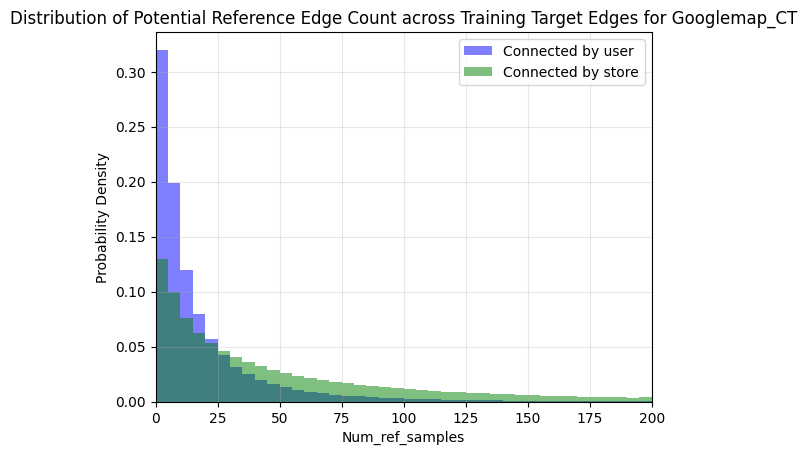

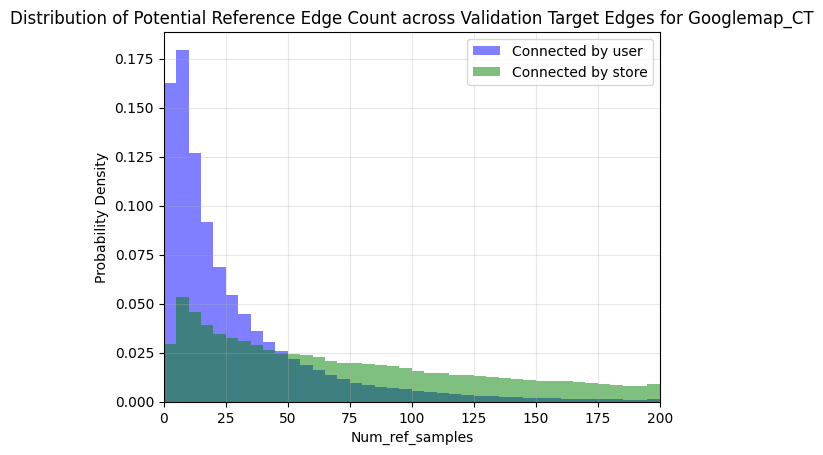

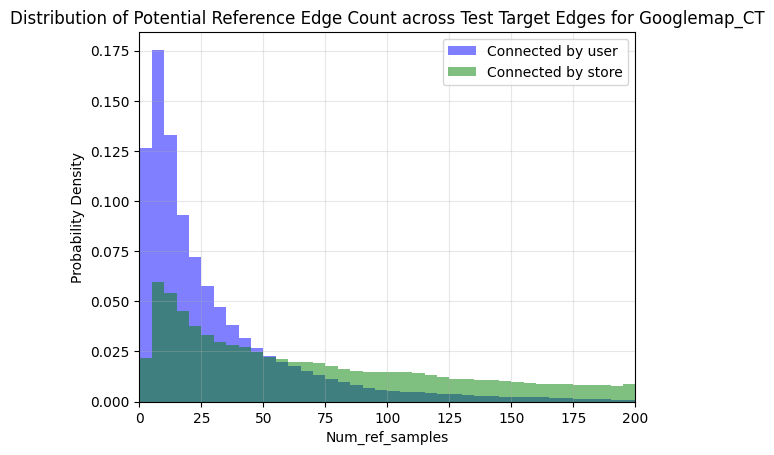

'\nGooglemaps\nNum nodes: 111169\nNum edges: 1380623\nNum timestamps: 55521\nMean edge text length: 127\n\nAmazon\nNum nodes: 293567\nNum edges: 1000000\nNum timestamps: 5484\nMean edge text length: 542\n'

In [ ]:
# Calculate number of edges, number of distinct nodes,
dataset_name = 'Googlemap_CT'
graph_df = pd.read_csv('../DyLink_Datasets/{}/edge_list.csv'.format(dataset_name, dataset_name))
node_num = max(graph_df['u'].max(), graph_df['i'].max()) + 1
edge_num = len(graph_df['r'])
timestamp_num = max(graph_df['ts']) + 1

print("Num nodes: " + str(node_num))
print("Num edges: " + str(edge_num))
print("Num timestamps: " + str(timestamp_num))

# Calculate the number of available reference edges
src_node_ids = graph_df.u.values.astype(np.longlong)
dst_node_ids = graph_df.i.values.astype(np.longlong)
src_count_dict = {}
dst_count_dict = {}
src_and_dst_count_dict = {}
src_counts = np.zeros(len(src_node_ids), dtype=int)
dst_counts = np.zeros(len(src_node_ids), dtype=int)
src_and_dst_counts = np.zeros(len(src_node_ids), dtype=int)
for i in range(len(src_node_ids)):
    src_counts[i] = src_count_dict.get(src_node_ids[i], 0)
    dst_counts[i] = dst_count_dict.get(dst_node_ids[i], 0)
    pair_key = (src_node_ids[i], dst_node_ids[i])
    src_and_dst_counts[i] = src_and_dst_count_dict.get(pair_key, 0)

    src_count_dict[src_node_ids[i]] = src_count_dict.get(src_node_ids[i], 0) + 1
    dst_count_dict[dst_node_ids[i]] = dst_count_dict.get(dst_node_ids[i], 0) + 1
    src_and_dst_count_dict[pair_key] = src_and_dst_count_dict.get(pair_key, 0) + 1

val_start_idx = int(0.7*len(src_node_ids))
test_start_idx = int(0.85*len(src_node_ids))
src_counts = src_counts - src_and_dst_counts
print("Median train user ref count: " + str(int(np.median(src_counts[0:val_start_idx]))))
print("Median val user ref count: " + str(int(np.median(src_counts[val_start_idx:test_start_idx]))))
print("Median test user ref count: " + str(int(np.median(src_counts[test_start_idx:]))))
dst_counts = dst_counts - src_and_dst_counts
print("Median train store ref count: " + str(int(np.median(dst_counts[0:val_start_idx]))))
print("Median val store ref count: " + str(int(np.median(dst_counts[val_start_idx:test_start_idx]))))
print("Median test store ref count: " + str(int(np.median(dst_counts[test_start_idx:]))))

# Calculate average relation text length
edge_texts = pd.read_csv('../DyLink_Datasets/' + dataset_name + '/relation_text.csv')
print("Mean edge text length: " + str(int(edge_texts['text'].str.len().mean())))

for start_idx, end_idx, data_label in [[0, val_start_idx, 'Training'], [val_start_idx, test_start_idx, 'Validation'], [test_start_idx, len(dst_counts), 'Test']]:
    sample_src_cts = src_counts[start_idx:end_idx]
    sample_dst_cts = dst_counts[start_idx:end_idx]
    weights1 = np.ones_like(sample_src_cts) / len(sample_src_cts)
    weights2 = np.ones_like(sample_dst_cts) / len(sample_dst_cts)
    plt.hist(sample_src_cts, alpha=0.5, label='Connected by user',
            color='blue', bins=40, weights=weights1, range=(0,200))
    plt.hist(sample_dst_cts, alpha=0.5, label='Connected by store' if dataset_name == 'Googlemap_CT' else 'Connected by item',
            color='green', bins=40, weights=weights2, range=(0,200))

    plt.xlabel('Num_ref_samples')
    plt.ylabel('Probability Density')
    plt.title('Distribution of Potential Reference Edge Count across ' + data_label + ' Target Edges for ' + dataset_name)

    # Show the plot
    plt.xlim(0, 200)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

"""
Googlemaps
Num nodes: 111169
Num edges: 1380623
Num timestamps: 55521
Mean edge text length: 127

Amazon
Num nodes: 293567
Num edges: 1000000
Num timestamps: 5484
Mean edge text length: 542
"""

## Setup and Train Model

In [ ]:
# load precomputed train/validation/test data
with open('../DyLink_Datasets/' + args.dataset_name + '/processed_data.pkl', 'rb') as file:
    processed_data = pickle.load(file)
node_raw_features, edge_raw_features, full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data, train_data_edges, full_data_edges = processed_data

# Normalize data and correct typing
lbl_min = train_data.labels.min()
lbl_max = train_data.labels.max()
for data in [full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data]:
    data.correct_typing()
    data.normalize_labels(lbl_min, lbl_max)

if args.classification:
    train_lbl_median = np.median(train_data.labels)
    for data in [full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data]:
        data.labels[data.labels > train_lbl_median] = 1
        data.labels[data.labels <= train_lbl_median] = 0


# initialize validation and test neighbor sampler to retrieve temporal graph
full_neighbor_sampler = get_neighbor_sampler(data=full_data, sample_neighbor_strategy=args.sample_neighbor_strategy,
                                                time_scaling_factor=args.time_scaling_factor, seed=1)

# can just use this full neighbor sampler in inductive setting b/c validation/test nodes are in the future --> won't be seen
train_neighbor_sampler = full_neighbor_sampler

skip_new_node_val = False

In [ ]:
# Quick sanity check: For every target-reference pair, either the source node ids of the target and reference should match or the ref node ids of the target and reference should match
print(train_data.src_node_ids[0:12])
print(train_data.dst_node_ids[0:12])
print(train_data.ref_src_node_ids[0:12])
print(train_data.ref_dst_node_ids[0:12])
print(train_data.ref_on_src_side[0:12])

[20137 50523 50523 50523 55845 55845 55845 27685 27685 27685 27685 21318]
[ 85231  86324  86324  86324  84466  84466  84466 103008 103008 103008
 103008  89521]
[15634    26 70215 50523 43394 11864 55845 48368 39088 27685 27685   119]
[ 85231  86324  86324  92230  84466  84466 106281 103008 103008  98554
  85863  89521]
[ True  True  True False  True False False  True  True  True False  True]


In [ ]:
## Train model

args.classification = False

# get data loaders
train_idx_data_loader = get_idx_data_loader(indices_list=list(range(len(train_data.src_node_ids))), batch_size=args.batch_size, shuffle=True)
val_idx_data_loader = get_idx_data_loader(indices_list=list(range(len(val_data.src_node_ids))), batch_size=args.batch_size, shuffle=True)
if not skip_new_node_val:
  new_node_val_idx_data_loader = get_idx_data_loader(indices_list=list(range(len(new_node_val_data.src_node_ids))), batch_size=args.batch_size, shuffle=True)

val_metric_all_runs, new_node_val_metric_all_runs = [], []

save_result_folder = f"./saved_results/{args.model_name}/{args.dataset_name}"
os.makedirs(save_result_folder, exist_ok=True)

for run in range(args.num_runs):

    set_random_seed(seed=run)

    args.seed = run
    args.save_model_name = f'{args.model_name}_seed{args.seed}{args.use_feature}_shared_8e'

    # set up logger
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    os.makedirs(f"./logs/{args.model_name}/{args.dataset_name}/{args.save_model_name}/", exist_ok=True)
    # create file handler that logs debug and higher level messages
    fh = logging.FileHandler(f"./logs/{args.model_name}/{args.dataset_name}/{args.save_model_name}/{str(time.time())}.log")
    fh.setLevel(logging.DEBUG)
    # create console handler with a higher log level
    ch = logging.StreamHandler()
    ch.setLevel(logging.WARNING)
    # create formatter and add it to the handlers
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to logger
    logger.addHandler(fh)
    logger.addHandler(ch)

    run_start_time = time.time()
    logger.info(f"********** Run {run + 1} starts. **********")

    logger.info(f'configuration is {args}')

    logger.info(f'node feature size {node_raw_features.shape}')
    logger.info(f'edge feature size {edge_raw_features.shape}')
    logger.info(f'node feature example {node_raw_features[1][:5]}')
    logger.info(f'edge feature example {edge_raw_features[1][:5]}')

    # create model
    dynamic_backbone = DyGFormer(node_raw_features=node_raw_features, edge_raw_features=edge_raw_features, neighbor_sampler=train_neighbor_sampler,
                                    time_feat_dim=args.time_feat_dim, channel_embedding_dim=args.channel_embedding_dim, patch_size=args.patch_size,
                                    num_layers=args.num_layers, num_heads=args.num_heads, dropout=args.dropout,
                                    max_input_sequence_length=args.max_input_sequence_length, device=args.device)

    recommender = NMergeLayer(input_dims=[node_raw_features.shape[1]] * 4,
                                hidden_dim=node_raw_features.shape[1] * 4, output_dim=2 if args.classification else 1)
    model = nn.Sequential(dynamic_backbone, recommender)
    logger.info(f'model -> {model}')
    logger.info(f'model name: {args.model_name}, #parameters: {get_parameter_sizes(model) * 4} B, '
                f'{get_parameter_sizes(model) * 4 / 1024} KB, {get_parameter_sizes(model) * 4 / 1024 / 1024} MB.')

    optimizer = create_optimizer(model=model, optimizer_name=args.optimizer, learning_rate=args.learning_rate, weight_decay=args.weight_decay)

    model = convert_to_gpu(model, device=args.device)

    save_model_folder = f"./saved_models/{args.model_name}/{args.dataset_name}/{args.save_model_name}/"
    shutil.rmtree(save_model_folder, ignore_errors=True)
    os.makedirs(save_model_folder, exist_ok=True)

    early_stopping = EarlyStopping(patience=args.patience, save_model_folder=save_model_folder,
                                    save_model_name=args.save_model_name, logger=logger, model_name=args.model_name)

    loss_func = nn.MSELoss()
    if args.classification:
        loss_func = nn.CrossEntropyLoss()

    for epoch in range(args.num_epochs):

        train_y_trues, train_y_predicts = [], []

        model.train()
        # training, only use training graph
        model[0].set_neighbor_sampler(train_neighbor_sampler)

        # store train losses and metrics
        train_losses, train_metrics = [], []
        train_idx_data_loader_tqdm = tqdm(train_idx_data_loader, ncols=120)
        for batch_idx, train_data_indices in enumerate(train_idx_data_loader_tqdm):
            train_data_indices = train_data_indices.numpy()

            # Get target edge predictions
            batch_tgt_src_node_ids, batch_tgt_dst_node_ids, batch_tgt_node_interact_times, batch_tgt_edge_ids, batch_labels = \
                train_data.src_node_ids[train_data_indices], train_data.dst_node_ids[train_data_indices], \
                train_data.node_interact_times[train_data_indices], train_data.edge_ids[train_data_indices], \
                train_data.labels[train_data_indices]

            batch_tgt_src_node_embeddings, batch_tgt_dst_node_embeddings = \
                model[0].compute_src_dst_node_temporal_embeddings(src_node_ids=batch_tgt_src_node_ids,
                                                                    dst_node_ids=batch_tgt_dst_node_ids,
                                                                    node_interact_times=batch_tgt_node_interact_times)

            # Get reference edge predictions
            batch_ref_src_node_ids, batch_ref_dst_node_ids, batch_ref_node_interact_times, batch_ref_edge_ids = \
                train_data.ref_src_node_ids[train_data_indices], train_data.ref_dst_node_ids[train_data_indices], \
                train_data.ref_node_interact_times[train_data_indices], train_data.ref_edge_ids[train_data_indices]

            batch_ref_src_node_embeddings, batch_ref_dst_node_embeddings = \
                model[0].compute_src_dst_node_temporal_embeddings(src_node_ids=batch_ref_src_node_ids,
                                                                    dst_node_ids=batch_ref_dst_node_ids,
                                                                    node_interact_times=batch_ref_node_interact_times)

            # get a prediction 0-1 based on how useful the reference edge will be in predicting the target edge
            # shape (batch_size, )
            ipts = [batch_tgt_src_node_embeddings, batch_tgt_dst_node_embeddings, batch_ref_src_node_embeddings, batch_ref_dst_node_embeddings]

            # Backprop loss
            loss = None
            if args.classification:
                predicts = model[1](inputs=ipts).sigmoid()
                loss = loss_func(input=predicts, target=batch_labels.long().to(args.device))
                pred_labels = torch.max(predicts, dim=1)[1]
                train_y_trues.append(batch_labels)
                train_y_predicts.append(pred_labels)
            else:
                predicts = model[1](inputs=ipts).squeeze(dim=-1).sigmoid()
                loss = loss_func(input=predicts, target=batch_labels.to(args.device))

            train_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_idx_data_loader_tqdm.set_description(f'Epoch: {epoch + 1}, train for the {batch_idx + 1}-th batch, train loss: {loss.item()}')

        if args.classification:
          train_y_trues = torch.cat(train_y_trues, dim=0)
          train_y_predicts = torch.cat(train_y_predicts, dim=0)
          train_metrics = get_edge_classification_metrics(predicts=train_y_predicts, labels=train_y_trues)
          for metric_name in train_metrics.keys():
            train_metric = train_metrics[metric_name]
            logger.info(f'train {metric_name}, {train_metric:.4f}')

        print("\n Average train loss: " + str(sum(train_losses)/len(train_losses)))


        if (epoch + 1) % args.test_interval_epochs == 0:

            val_losses, val_metrics, _ = evaluate_model_link_recommendation(model_name=args.model_name,
                                                                    model=model,
                                                                    neighbor_sampler=full_neighbor_sampler,
                                                                    evaluate_idx_data_loader=val_idx_data_loader,
                                                                    evaluate_data=val_data,
                                                                    edge_raw_features=edge_raw_features,
                                                                    loss_func=loss_func,
                                                                    num_neighbors=args.num_neighbors,
                                                                    time_gap=args.time_gap,
                                                                    use_classification_metrics = args.classification)
            if not skip_new_node_val:
              new_node_val_losses, new_node_val_metrics, _ = evaluate_model_link_recommendation(model_name=args.model_name,
                                                                                      model=model,
                                                                                      neighbor_sampler=full_neighbor_sampler,
                                                                                      evaluate_idx_data_loader=new_node_val_idx_data_loader,
                                                                                      evaluate_data=new_node_val_data,
                                                                                      edge_raw_features=edge_raw_features,
                                                                                      loss_func=loss_func,
                                                                                      num_neighbors=args.num_neighbors,
                                                                                      time_gap=args.time_gap,
                                                                                      use_classification_metrics = args.classification)

            logger.info(f'Epoch: {epoch + 1}, learning rate: {optimizer.param_groups[0]["lr"]}, train loss: {np.mean(train_losses):.4f}')
            #for metric_name in train_metrics[0].keys():
            #    logger.info(f'train {metric_name}, {np.mean([train_metric[metric_name] for train_metric in train_metrics]):.4f}')
            logger.info(f'validate loss: {np.mean(val_losses):.4f}')
            if args.classification:
              for metric_name in val_metrics.keys():
                val_metric = val_metrics[metric_name]
                logger.info(f'validate {metric_name}, {val_metric:.4f}')

            early_stop = early_stopping.step([], model)

            if early_stop:
                break

    # load the best model
    early_stopping.load_checkpoint(model)

    # evaluate the best model
    logger.info(f'get final performance on dataset {args.dataset_name}...')

    # the saved best model of memory-based models cannot perform validation since the stored memory has been updated by validation data
    val_losses, val_metrics, _ = evaluate_model_link_recommendation(model_name=args.model_name,
                                                                model=model,
                                                                neighbor_sampler=full_neighbor_sampler,
                                                                evaluate_idx_data_loader=val_idx_data_loader,
                                                                evaluate_data=val_data,
                                                                edge_raw_features=edge_raw_features,
                                                                loss_func=loss_func,
                                                                num_neighbors=args.num_neighbors,
                                                                time_gap=args.time_gap,
                                                                use_classification_metrics = args.classification)

    if not skip_new_node_val:
      new_node_val_losses, new_node_val_metrics, _ = evaluate_model_link_recommendation(model_name=args.model_name,
                                                                                  model=model,
                                                                                  neighbor_sampler=full_neighbor_sampler,
                                                                                  evaluate_idx_data_loader=new_node_val_idx_data_loader,
                                                                                  evaluate_data=new_node_val_data,
                                                                                  edge_raw_features=edge_raw_features,
                                                                                  loss_func=loss_func,
                                                                                  num_neighbors=args.num_neighbors,
                                                                                  time_gap=args.time_gap,
                                                                                    use_classification_metrics = args.classification)

    # store the evaluation metrics at the current run
    val_metric_dict, new_node_val_metric_dict = {}, {}

    logger.info(f'validate loss: {np.mean(val_losses):.4f}')

    if not skip_new_node_val:
      logger.info(f'new node validate loss: {np.mean(new_node_val_losses):.4f}')

    single_run_time = time.time() - run_start_time
    logger.info(f'Run {run + 1} cost {single_run_time:.2f} seconds.')

    val_metric_all_runs.append(val_metric_dict)
    if not skip_new_node_val:
      new_node_val_metric_all_runs.append(new_node_val_metric_dict)

    # avoid the overlap of logs
    if run < args.num_runs - 1:
        logger.removeHandler(fh)
        logger.removeHandler(ch)

    # save model result
    if not skip_new_node_val:
      result_json = {
          "validate metrics": {metric_name: f'{val_metric_dict[metric_name]:.4f}' for metric_name in val_metric_dict},
          "new node validate metrics": {metric_name: f'{new_node_val_metric_dict[metric_name]:.4f}' for metric_name in new_node_val_metric_dict},
      }
    else:
      result_json = {
          "validate metrics": {metric_name: f'{val_metric_dict[metric_name]:.4f}' for metric_name in val_metric_dict},
      }
    result_json = json.dumps(result_json, indent=4)

    save_result_path = os.path.join(save_result_folder, f"{args.save_model_name}{epoch}.json")

    with open(save_result_path, 'w') as file:
        file.write(result_json)

INFO:root:********** Run 1 starts. **********
INFO:root:configuration is Namespace(dataset_name='Googlemap_CT', batch_size=256, model_name='DyGFormer', gpu=0, num_neighbors=20, sample_neighbor_strategy='recent', time_scaling_factor=1e-06, num_walk_heads=8, num_heads=2, num_layers=2, walk_length=1, time_gap=2000, time_feat_dim=100, position_feat_dim=768, edge_bank_memory_mode='unlimited_memory', time_window_mode='fixed_proportion', patch_size=1, channel_embedding_dim=50, max_input_sequence_length=48, learning_rate=0.0001, dropout=0.1, num_epochs=8, optimizer='Adam', weight_decay=0.0, patience=5, val_ratio=0.15, test_ratio=0.15, num_runs=1, test_interval_epochs=1, negative_sample_strategy='random', use_feature='Bert', load_best_configs=True, device='cuda:0', time_dim=768, classification=False, seed=0, save_model_name='DyGFormer_seed0Bert_shared_8e')
INFO:root:node feature size (111169, 768)
INFO:root:edge feature size (1196501, 768)
INFO:root:node feature example [-0.86001182 -0.35063297


 Average train loss: 0.009531211202958472


evaluate for the 392-th batch, evaluate loss: 0.007457818370312452: 100%|█████████████| 392/392 [01:31<00:00,  4.30it/s]
evaluate for the 169-th batch, evaluate loss: 0.00891470443457365: 100%|██████████████| 169/169 [00:39<00:00,  4.28it/s]
INFO:root:Epoch: 1, learning rate: 0.0001, train loss: 0.0095
INFO:root:validate loss: 0.0094
INFO:root:new node validate loss: 0.0087
INFO:root:save model ./saved_models/DyGFormer/Googlemap_CT/DyGFormer_seed0Bert_shared_8e/DyGFormer_seed0Bert_shared_8e.pkl
Epoch: 2, train for the 1956-th batch, train loss: 0.012627285905182362: 100%|██████| 1956/1956 [07:52<00:00,  4.14it/s]



 Average train loss: 0.009260026580684557


evaluate for the 392-th batch, evaluate loss: 0.008348916657269001: 100%|█████████████| 392/392 [01:30<00:00,  4.32it/s]
evaluate for the 169-th batch, evaluate loss: 0.010027599520981312: 100%|█████████████| 169/169 [00:39<00:00,  4.28it/s]
INFO:root:Epoch: 2, learning rate: 0.0001, train loss: 0.0093
INFO:root:validate loss: 0.0095
INFO:root:new node validate loss: 0.0090
INFO:root:save model ./saved_models/DyGFormer/Googlemap_CT/DyGFormer_seed0Bert_shared_8e/DyGFormer_seed0Bert_shared_8e.pkl
Epoch: 3, train for the 1956-th batch, train loss: 0.009675635024905205: 100%|██████| 1956/1956 [07:52<00:00,  4.14it/s]



 Average train loss: 0.009206540921630608


evaluate for the 392-th batch, evaluate loss: 0.008221408352255821: 100%|█████████████| 392/392 [01:30<00:00,  4.32it/s]
evaluate for the 169-th batch, evaluate loss: 0.01017468050122261: 100%|██████████████| 169/169 [00:39<00:00,  4.27it/s]
INFO:root:Epoch: 3, learning rate: 0.0001, train loss: 0.0092
INFO:root:validate loss: 0.0094
INFO:root:new node validate loss: 0.0088
INFO:root:save model ./saved_models/DyGFormer/Googlemap_CT/DyGFormer_seed0Bert_shared_8e/DyGFormer_seed0Bert_shared_8e.pkl
Epoch: 4, train for the 1956-th batch, train loss: 0.007731018587946892: 100%|██████| 1956/1956 [07:52<00:00,  4.14it/s]



 Average train loss: 0.009169386860967856


evaluate for the 392-th batch, evaluate loss: 0.007852316834032536: 100%|█████████████| 392/392 [01:30<00:00,  4.31it/s]
evaluate for the 169-th batch, evaluate loss: 0.009187409654259682: 100%|█████████████| 169/169 [00:39<00:00,  4.29it/s]
INFO:root:Epoch: 4, learning rate: 0.0001, train loss: 0.0092
INFO:root:validate loss: 0.0094
INFO:root:new node validate loss: 0.0088
INFO:root:save model ./saved_models/DyGFormer/Googlemap_CT/DyGFormer_seed0Bert_shared_8e/DyGFormer_seed0Bert_shared_8e.pkl
Epoch: 5, train for the 1956-th batch, train loss: 0.008637362159788609: 100%|██████| 1956/1956 [07:52<00:00,  4.14it/s]



 Average train loss: 0.009111352337491918


evaluate for the 392-th batch, evaluate loss: 0.00889547262340784: 100%|██████████████| 392/392 [01:30<00:00,  4.33it/s]
evaluate for the 169-th batch, evaluate loss: 0.009038623422384262: 100%|█████████████| 169/169 [00:39<00:00,  4.29it/s]
INFO:root:Epoch: 5, learning rate: 0.0001, train loss: 0.0091
INFO:root:validate loss: 0.0095
INFO:root:new node validate loss: 0.0087
INFO:root:save model ./saved_models/DyGFormer/Googlemap_CT/DyGFormer_seed0Bert_shared_8e/DyGFormer_seed0Bert_shared_8e.pkl
Epoch: 6, train for the 1956-th batch, train loss: 0.007868276908993721: 100%|██████| 1956/1956 [07:53<00:00,  4.13it/s]



 Average train loss: 0.009028826378607753


evaluate for the 392-th batch, evaluate loss: 0.008904452435672283: 100%|█████████████| 392/392 [01:31<00:00,  4.30it/s]
evaluate for the 169-th batch, evaluate loss: 0.009495378471910954: 100%|█████████████| 169/169 [00:39<00:00,  4.28it/s]
INFO:root:Epoch: 6, learning rate: 0.0001, train loss: 0.0090
INFO:root:validate loss: 0.0096
INFO:root:new node validate loss: 0.0091
INFO:root:save model ./saved_models/DyGFormer/Googlemap_CT/DyGFormer_seed0Bert_shared_8e/DyGFormer_seed0Bert_shared_8e.pkl
Epoch: 7, train for the 1956-th batch, train loss: 0.012103426270186901: 100%|██████| 1956/1956 [07:53<00:00,  4.13it/s]



 Average train loss: 0.008971263778801619


evaluate for the 392-th batch, evaluate loss: 0.013009285554289818: 100%|█████████████| 392/392 [01:30<00:00,  4.31it/s]
evaluate for the 169-th batch, evaluate loss: 0.00966092199087143: 100%|██████████████| 169/169 [00:39<00:00,  4.30it/s]
INFO:root:Epoch: 7, learning rate: 0.0001, train loss: 0.0090
INFO:root:validate loss: 0.0093
INFO:root:new node validate loss: 0.0088
INFO:root:save model ./saved_models/DyGFormer/Googlemap_CT/DyGFormer_seed0Bert_shared_8e/DyGFormer_seed0Bert_shared_8e.pkl
Epoch: 8, train for the 1956-th batch, train loss: 0.006009221076965332: 100%|██████| 1956/1956 [07:52<00:00,  4.14it/s]



 Average train loss: 0.008932435224670727


evaluate for the 392-th batch, evaluate loss: 0.009226378984749317: 100%|█████████████| 392/392 [01:31<00:00,  4.29it/s]
evaluate for the 169-th batch, evaluate loss: 0.008630815893411636: 100%|█████████████| 169/169 [00:39<00:00,  4.28it/s]
INFO:root:Epoch: 8, learning rate: 0.0001, train loss: 0.0089
INFO:root:validate loss: 0.0091
INFO:root:new node validate loss: 0.0087
INFO:root:save model ./saved_models/DyGFormer/Googlemap_CT/DyGFormer_seed0Bert_shared_8e/DyGFormer_seed0Bert_shared_8e.pkl
INFO:root:load model ./saved_models/DyGFormer/Googlemap_CT/DyGFormer_seed0Bert_shared_8e/DyGFormer_seed0Bert_shared_8e.pkl
INFO:root:get final performance on dataset Googlemap_CT...
evaluate for the 392-th batch, evaluate loss: 0.008306842297315598: 100%|█████████████| 392/392 [01:30<00:00,  4.32it/s]
evaluate for the 169-th batch, evaluate loss: 0.009050721302628517: 100%|█████████████| 169/169 [00:39<00:00,  4.28it/s]
INFO:root:validate loss: 0.0091
INFO:root:new node validate loss: 0.0087
INF

## Evaluate Model

In [ ]:
"""
Add validation metric that's like the relative ranking of reference edges

Model scores all predicted within a small window, but maybe? This is ok because maybe all the model needs is to show this bias for some samples over others
For 5000 random validation edges, find up to 50 possible reference edges per side. Compare orderings from model against ground truth

"""

args.classification = False

from scipy.stats import kendalltau

with open('../DyLink_Datasets/' + args.dataset_name + '/processed_data.pkl', 'rb') as file:
    processed_data = pickle.load(file)
node_raw_features, edge_raw_features, full_data, train_data, val_data, test_data, new_node_val_data, new_node_test_data, train_data_edges, full_data_edges = processed_data

data = val_data.copy()
n_val_edges = 2000
max_n_per_ranking = 50

# Fetch model
dynamic_backbone = DyGFormer(node_raw_features=node_raw_features, edge_raw_features=edge_raw_features, neighbor_sampler=train_neighbor_sampler,
                                time_feat_dim=args.time_feat_dim, channel_embedding_dim=args.channel_embedding_dim, patch_size=args.patch_size,
                                num_layers=args.num_layers, num_heads=args.num_heads, dropout=args.dropout,
                                max_input_sequence_length=args.max_input_sequence_length, device=args.device)
recommender = NMergeLayer(input_dims=[node_raw_features.shape[1]] * 4,
                            hidden_dim=node_raw_features.shape[1] * 4, output_dim=2 if args.classification else 1)
model = nn.Sequential(dynamic_backbone, recommender)
args.save_model_name = f'{args.model_name}_seed0{args.use_feature}'
save_model_location = f"../Code/saved_models/{args.model_name}/{args.dataset_name}/{args.save_model_name}_shared_8e_final/DyGFormer_seed0Bert_shared_8e.pkl" # #_save2e/DyGFormer_seed0Bert.pkl"
model.load_state_dict(torch.load(save_model_location))
model = convert_to_gpu(model, device=args.device)
loss_func = nn.MSELoss()

# load data
edge_texts = pd.read_csv('../DyLink_Datasets/' + args.dataset_name + '/relation_text.csv')

mask = np.zeros(len(data.ref_src_node_ids), dtype=bool)
random_indices = np.random.choice(len(data.ref_src_node_ids), size=n_val_edges, replace=False)
mask[random_indices] = True

data.apply_mask(mask)
data = data.calc_ref_edges(train_data_edges, max_n_per_ranking, edge_texts)
data.correct_typing()

data_loader = get_idx_data_loader(indices_list=list(range(len(data.src_node_ids))), batch_size=args.batch_size, shuffle=False)

# Run forward passes of model
_, _, predicts = evaluate_model_link_recommendation(model_name=args.model_name,
                                                                model=model,
                                                                neighbor_sampler=full_neighbor_sampler,
                                                                evaluate_idx_data_loader=data_loader,
                                                                evaluate_data=data,
                                                                edge_raw_features=edge_raw_features,
                                                                loss_func=loss_func,
                                                                num_neighbors=args.num_neighbors,
                                                                time_gap=args.time_gap,
                                                                use_classification_metrics = args.classification,
                                                                only_need_predicts = True)

# Compute scores
target_edge_ids = dict.fromkeys(data.edge_ids).keys()
src_mask = (data.ref_on_src_side == True)
dst_mask = (data.ref_on_src_side == False)

model_labels = np.array(predicts, dtype=np.float32)
actual_labels = np.array(data.labels, dtype=np.float32)

src_score = 0.0
dst_score = 0.0
print("\n")
for target_edge_id in target_edge_ids:
    edge_mask = (data.edge_ids == target_edge_id)
    for side_mask, side_mask_name in [[src_mask, 'src'], [dst_mask, 'dst']]:
        combined_mask = np.logical_and(edge_mask, side_mask)
        model_rank = model_labels[combined_mask].size - np.argsort(model_labels[combined_mask].argsort())
        actual_rank = actual_labels[combined_mask].size - np.argsort(actual_labels[combined_mask].argsort())
        if(model_rank.shape[0] < 2):
          continue
        if side_mask_name == 'src':
            src_score += kendalltau(model_rank, actual_rank).statistic
        else:
            dst_score += kendalltau(model_rank, actual_rank).statistic

src_score /= len(target_edge_ids)
dst_score /= len(target_edge_ids)

print(src_score)
print(dst_score)

0


evaluate for the 427-th batch, evaluate loss: 0.052283335477113724: 100%|█████████████| 427/427 [01:34<00:00,  4.50it/s]




0.45731103455069577
0.03314218629744732
